# OIH Graph Pre-Processor

## About
This notebook demonstrates some approaches for processing the release graphs into a format that
is useful for the Dashboard UI

#### WMO Note

For WMO we need to add to the sparqlwmo an optional temporal aspect.  The output should be set as GeoJSON

#### ROA

Resource-Oriented Architecture (ROA) is an architectural style for designing network-based software applications. This style prioritizes resources, their identification, representation, and the links between them over the actions performed on those resources (as in many object-oriented architectures).

Here are key principles of ROA:

1. **Resources:** In a ROA, every piece of information and service is considered a resource. These resources are identifiable and can be accessed through a unique identifier, typically a URI.

2. **Links and Connectedness:** Resources reference each other through links, creating a web of interconnected resources. This allows for easy navigation between related resources.

3. **Standard Methods:** In ROA, resources are manipulated using standard HTTP methods (like GET, POST, PUT, DELETE). This makes the API predictable and easy to understand.

4. **Representation-Oriented:** Rather than being concerned with implementation details, ROA focuses on how resources are represented to clients. Different clients might receive different representations of the same resource.

5. **Stateless:** Similar to RESTful systems, ROA prefers stateless operations, where each request from client to server must contain all the information necessary to understand and respond to the request.

6. **Addressability:** Every resource has a unique address, typically a URL, which can be bookmarked, typed into a browser, or passed around by an application.

ROA is most notably realized in the design of RESTful APIs, which are intended to interact with web resources. It's focused on leveraging the protocols and technologies of the web (like HTTP, URIs, and MIME types) rather than creating new standards or protocols.


### Imports and definitions

In [47]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)  ## remove pandas future warning
import pandas as pd
import geopandas as gpd
from shapely import wkt
import s3fs
import pyarrow.parquet as pq
import shapely
import os
import re
import kglab
from minio import Minio
import rdflib
from rdflib import ConjunctiveGraph  #  needed for nquads

In [2]:
def publicurls(client, bucket, prefix):
    urls = []
    objects = client.list_objects(bucket, prefix=prefix, recursive=True)
    for obj in objects:
        result = client.stat_object(bucket, obj.object_name)

        if result.size > 0:  #  how to tell if an objet   obj.is_public  ?????
            url = client.presigned_get_object(bucket, obj.object_name)
            # print(f"Public URL for object: {url}")
            urls.append(url)

    return urls

In [43]:
def to_wkt(polygon_string):
    # split the input string into pairs
    pairs = polygon_string.split(',')

    # transform each pair into 'y x' format
    transformed_pairs = [' '.join(reversed(pair.split())) for pair in pairs]

    # join the transformed pairs with a comma and a space
    transformed_string = ', '.join(transformed_pairs)

    # return the final WKT string
    return f"POLYGON (({transformed_string}))"

In [3]:
# Check for using GPU, in case you want to ensure your GPU is used
# gc = kglab.get_gpu_count()
# print(gc)

0


In [4]:
client = Minio("ossapi.oceaninfohub.org:80",  secure=False) # Create client with anonymous access.
urls = publicurls(client, "public", "graph")

In [5]:
print(urls)

['http://ossapi.oceaninfohub.org/public/graphs/summonedafricaioc_v1_release.nq', 'http://ossapi.oceaninfohub.org/public/graphs/summonedaquadocs_v1_release.nq', 'http://ossapi.oceaninfohub.org/public/graphs/summonedcioos_v1_release.nq', 'http://ossapi.oceaninfohub.org/public/graphs/summonededmerp_v1_release.nq', 'http://ossapi.oceaninfohub.org/public/graphs/summonededmo_v1_release.nq', 'http://ossapi.oceaninfohub.org/public/graphs/summonedemodnet_v1_release.nq', 'http://ossapi.oceaninfohub.org/public/graphs/summonedinanodc_v1_release.nq', 'http://ossapi.oceaninfohub.org/public/graphs/summonedinvemardocuments_v1_release.nq', 'http://ossapi.oceaninfohub.org/public/graphs/summonedinvemarexperts_v1_release.nq', 'http://ossapi.oceaninfohub.org/public/graphs/summonedinvemarinstitutions_v1_release.nq', 'http://ossapi.oceaninfohub.org/public/graphs/summonedinvemartraining_v1_release.nq', 'http://ossapi.oceaninfohub.org/public/graphs/summonedinvemarvessels_v1_release.nq', 'http://ossapi.oceaninf

## Query sets


In [33]:
sparql = """
PREFIX schema: <https://schema.org/>
PREFIX schemawrong: <http://schema.org/>


SELECT ?s ?type ?desc ?name ?url ?keywords
WHERE
{
 ?s rdf:type ?type
   FILTER ( ?type IN (schema:ResearchProject, schema:Project, schema:Organization,
   schema:Dataset, schema:CreativeWork, schema:Person, schema:Map, schema:Course,
   schema:CourseInstance, schema:Event, schema:Vehicle) )
   ?s schema:description ?desc .
   ?s schema:name ?name
       OPTIONAL { ?s schema:url ?url .   }
   ?s schema:keywords ?keywords

}
"""

sparqlcore = """
PREFIX schema: <https://schema.org/>
PREFIX schemawrong: <http://schema.org/>


SELECT ?g ?s ?type ?desc ?name ?url ?keywords
WHERE
{
     ?s rdf:type ?type
    FILTER ( ?type IN (schema:ResearchProject, schema:Project, schema:Organization,
    schema:Dataset, schema:CreativeWork, schema:Person, schema:Map, schema:Course,
    schema:CourseInstance, schema:Event, schema:Vehicle,   schemawrong:ResearchProject, schemawrong:Project, schemawrong:Organization,
    schemawrong:Dataset, schemawrong:CreativeWork, schemawrong:Person, schemawrong:Map, schemawrong:Course,
    schemawrong:CourseInstance, schemawrong:Event, schemawrong:Vehicle  ) )
    OPTIONAL {?s schema:description | schemawrong:description  ?desc .}
    OPTIONAL {?s schema:name | schemawrong:name ?name }
    OPTIONAL { ?s schema:url | schemawrong:url ?url .   }
    OPTIONAL {?s schema:keywords | schemawrong:keywords ?keywords}
 }
"""

#  What if we didn't make it optional and just made a "spatial product"
sparqlgeo = """
PREFIX schema: <https://schema.org/>
PREFIX schemawrong: <http://schema.org/>

SELECT ?geo ?geotype ?geompred ?geom
WHERE
{
    ?s rdf:type ?type
    FILTER ( ?type IN (schema:ResearchProject, schema:Project, schema:Organization,
    schema:Dataset, schema:CreativeWork, schema:Person, schema:Map, schema:Course,
    schema:CourseInstance, schema:Event, schema:Vehicle,   schemawrong:ResearchProject, schemawrong:Project, schemawrong:Organization,
    schemawrong:Dataset, schemawrong:CreativeWork, schemawrong:Person, schemawrong:Map, schemawrong:Course,
    schemawrong:CourseInstance, schemawrong:Event, schemawrong:Vehicle  ) )
    ?s schema:name | schemawrong:name ?name .
     ?s schema:spatialCoverage ?sc .
      ?sc a  schema:Place .
      ?sc schema:geo ?geo .
      ?geo a ?geotype .
      ?geo ?geompred ?geom
}
"""

sparqltesting = """
PREFIX schema: <https://schema.org/>
PREFIX schemawrong: <http://schema.org/>

SELECT *
WHERE
{
    ?s rdf:type ?type
    FILTER ( ?type IN (schema:ResearchProject, schema:Project, schema:Organization,
    schema:Dataset, schema:CreativeWork, schema:Person, schema:Map, schema:Course,
    schema:CourseInstance, schema:Event, schema:Vehicle,   schemawrong:ResearchProject, schemawrong:Project, schemawrong:Organization,
    schemawrong:Dataset, schemawrong:CreativeWork, schemawrong:Person, schemawrong:Map, schemawrong:Course,
    schemawrong:CourseInstance, schemawrong:Event, schemawrong:Vehicle  ) )
    ?s schema:name | schemawrong:name ?name
    OPTIONAL {  ?s schema:keywords | schemawrong:keywords ?keywords }
    OPTIONAL { ?s schema:description | schemawrong:description  ?desc . }
    OPTIONAL { ?s schema:url | schemawrong:url ?url .   }
    OPTIONAL {?s schema:keywords | schemawrong:keywords ?keywords}
    OPTIONAL { ?s schema:spatialCoverage ?sc .
      ?sc a  schema:Place .
      ?sc schema:geo ?geo .
      ?geo a ?geotype .
      ?geo schema:polygon ?geom
    }
}
"""

sparqlwmo = """
PREFIX schema: <https://schema.org/>
PREFIX schemawrong: <http://schema.org/>

SELECT DISTINCT ?s ?name ?description ?geotype ?geompred ?geom
WHERE
{
    ?s rdf:type ?type
    FILTER ( ?type IN (schema:Dataset, schemawrong:Dataset  ) )
    ?s schema:name | schemawrong:name ?name .
    ?s schema:description | schemawrong:description ?description .
    ?s schema:spatialCoverage ?sc .
    ?sc a  schema:Place .
    ?sc schema:geo ?geo .
    ?geo a ?geotype .
    ?geo ?geompred ?geom .
    FILTER(!isIRI(?geom))
}
"""

## Single Graph Test

At this point we have the URLs, and we could either loop load all of them or pull one out manually and use.  This section dmonstrates loading and working with one


In [39]:
# load quad graph
g = ConjunctiveGraph()
g.parse("http://ossapi.oceaninfohub.org/public/graphs/summonedobis_v1_release.nq", format="nquads")
print(len(g))

161187


In [40]:
namespaces = {
    "shacl":   "http://www.w3.org/ns/shacl#" ,
    "schema":   "https://schema.org/" ,
    "schemawrong": "http://schema.org/",
    "geo":      "http://www.opengis.net/ont/geosparql#",
}

kg = kglab.KnowledgeGraph(name = "OIH test", base_uri = "https://oceaninfohub.org/id/", namespaces = namespaces, use_gpus=True, import_graph = g)

In [41]:
pdf = kg.query_as_df(sparqlwmo)
# df = pdf   # .to_pandas()  #  breaks with papermill for reasons unknown at this time if to_pandas() is used, needed in my kglab conda env
# pdf.info()

In [44]:
pdf['WKT'] = pdf['geom'].apply(to_wkt)


In [45]:
pdf.head(20)


,s,name,description,geotype,geompred,geom,WKT
0,<https://obis.org/dataset/1057a007-c31c-48a3-a...,Census of annual pup production by Australian ...,"In Australia, it is thought that up to 26 Aust...",schema:GeoShape,schema:polygon,"135.96667 -43.63333,135.96667 -35.01667,150.23...","POLYGON ((-43.63333 135.96667, -35.01667 135.9..."
1,<https://obis.org/dataset/d64477cf-491f-4de5-8...,Canary Islands - OAG (aggregated per 1-degree ...,Original provider:\nObservatorio Ambiental Gra...,schema:GeoShape,schema:polygon,"-74.5 5.5,-74.5 45.5,32.5 45.5,32.5 5.5,-74.5 5.5","POLYGON ((5.5 -74.5, 45.5 -74.5, 45.5 32.5, 5...."
2,<https://obis.org/dataset/e71d452f-615e-4654-b...,Virginia and Maryland Sea Turtle Research and ...,Original provider:\nVirginia Aquarium and Mari...,schema:GeoShape,schema:polygon,"-76.39647 36.58278,-76.39647 38.52142,-74.3984...","POLYGON ((36.58278 -76.39647, 38.52142 -76.396..."
3,<https://obis.org/dataset/49f74e10-b23b-4aca-a...,"Species assemblages, biomass and regional habi...",Tow video and epibenthic sled collections were...,schema:GeoShape,schema:polygon,"124.05919 -15.94544,124.05919 -15.22044,124.69...","POLYGON ((-15.94544 124.05919, -15.22044 124.0..."
4,<https://obis.org/dataset/9a37fc55-1fc8-4c19-b...,PIROP Northwest Atlantic 1965-1992,Original provider:\nCanadian Wildlife Service\...,schema:GeoShape,schema:polygon,"-149.5667 -25.15,-149.5667 79.7833,18.5667 79....","POLYGON ((-25.15 -149.5667, 79.7833 -149.5667,..."
5,<https://obis.org/dataset/1d81a51c-66fc-46bf-a...,USWTR JAX Aerial Survey -Left side- 2011-2012,Original provider:\nUniversity of North Caroli...,schema:GeoShape,schema:polygon,"-80.690317 29.954577,-80.690317 30.574196,-79....","POLYGON ((29.954577 -80.690317, 30.574196 -80...."
6,<https://obis.org/dataset/a595a9a0-642a-473f-8...,Electronic Atlas of Ichthyoplankton on the Sco...,The EAISSNA database contains information on l...,schema:GeoShape,schema:polygon,"-73.5 12.5,-73.5 56,55 56,55 12.5,-73.5 12.5","POLYGON ((12.5 -73.5, 56 -73.5, 56 55, 12.5 55..."
7,<https://obis.org/dataset/32948ff1-6f03-4877-b...,Happywhale - Bryde's whale in South Atlantic O...,Original provider:\nHappywhale\n\nDataset cred...,schema:GeoShape,schema:polygon,"18.291666 -34.501803,18.291666 -34.058889,19.3...","POLYGON ((-34.501803 18.291666, -34.058889 18...."
8,<https://obis.org/dataset/0abb8cc1-8651-4213-a...,Colección de Gusanos Cinta (Nemertea) de la re...,El phylum Nemertea está formado por un pequeño...,schema:GeoShape,schema:polygon,"-74.32758 10.97982,-74.32758 11.26469,-74.1913...","POLYGON ((10.97982 -74.32758, 11.26469 -74.327..."
9,<https://obis.org/dataset/937da8a1-06b0-40ad-8...,BOLD - Australian records,"Barcode of Life data extract, October 2010\n\n...",schema:GeoShape,schema:polygon,"67.083 -56.733,67.083 -9.367,168.41701 -9.367,...","POLYGON ((-56.733 67.083, -9.367 67.083, -9.36..."


### Convert to geoPandas

In [48]:
pdf['geometry'] = pdf['WKT'].apply(wkt.loads)

gdf = gpd.GeoDataFrame(pdf, geometry='geometry')


In [49]:
gdf.head(20)

,s,name,description,geotype,geompred,geom,WKT,geometry
0,<https://obis.org/dataset/1057a007-c31c-48a3-a...,Census of annual pup production by Australian ...,"In Australia, it is thought that up to 26 Aust...",schema:GeoShape,schema:polygon,"135.96667 -43.63333,135.96667 -35.01667,150.23...","POLYGON ((-43.63333 135.96667, -35.01667 135.9...","POLYGON ((-43.633 135.967, -35.017 135.967, -3..."
1,<https://obis.org/dataset/d64477cf-491f-4de5-8...,Canary Islands - OAG (aggregated per 1-degree ...,Original provider:\nObservatorio Ambiental Gra...,schema:GeoShape,schema:polygon,"-74.5 5.5,-74.5 45.5,32.5 45.5,32.5 5.5,-74.5 5.5","POLYGON ((5.5 -74.5, 45.5 -74.5, 45.5 32.5, 5....","POLYGON ((5.500 -74.500, 45.500 -74.500, 45.50..."
2,<https://obis.org/dataset/e71d452f-615e-4654-b...,Virginia and Maryland Sea Turtle Research and ...,Original provider:\nVirginia Aquarium and Mari...,schema:GeoShape,schema:polygon,"-76.39647 36.58278,-76.39647 38.52142,-74.3984...","POLYGON ((36.58278 -76.39647, 38.52142 -76.396...","POLYGON ((36.583 -76.396, 38.521 -76.396, 38.5..."
3,<https://obis.org/dataset/49f74e10-b23b-4aca-a...,"Species assemblages, biomass and regional habi...",Tow video and epibenthic sled collections were...,schema:GeoShape,schema:polygon,"124.05919 -15.94544,124.05919 -15.22044,124.69...","POLYGON ((-15.94544 124.05919, -15.22044 124.0...","POLYGON ((-15.945 124.059, -15.220 124.059, -1..."
4,<https://obis.org/dataset/9a37fc55-1fc8-4c19-b...,PIROP Northwest Atlantic 1965-1992,Original provider:\nCanadian Wildlife Service\...,schema:GeoShape,schema:polygon,"-149.5667 -25.15,-149.5667 79.7833,18.5667 79....","POLYGON ((-25.15 -149.5667, 79.7833 -149.5667,...","POLYGON ((-25.150 -149.567, 79.783 -149.567, 7..."
5,<https://obis.org/dataset/1d81a51c-66fc-46bf-a...,USWTR JAX Aerial Survey -Left side- 2011-2012,Original provider:\nUniversity of North Caroli...,schema:GeoShape,schema:polygon,"-80.690317 29.954577,-80.690317 30.574196,-79....","POLYGON ((29.954577 -80.690317, 30.574196 -80....","POLYGON ((29.955 -80.690, 30.574 -80.690, 30.5..."
6,<https://obis.org/dataset/a595a9a0-642a-473f-8...,Electronic Atlas of Ichthyoplankton on the Sco...,The EAISSNA database contains information on l...,schema:GeoShape,schema:polygon,"-73.5 12.5,-73.5 56,55 56,55 12.5,-73.5 12.5","POLYGON ((12.5 -73.5, 56 -73.5, 56 55, 12.5 55...","POLYGON ((12.500 -73.500, 56.000 -73.500, 56.0..."
7,<https://obis.org/dataset/32948ff1-6f03-4877-b...,Happywhale - Bryde's whale in South Atlantic O...,Original provider:\nHappywhale\n\nDataset cred...,schema:GeoShape,schema:polygon,"18.291666 -34.501803,18.291666 -34.058889,19.3...","POLYGON ((-34.501803 18.291666, -34.058889 18....","POLYGON ((-34.502 18.292, -34.059 18.292, -34...."
8,<https://obis.org/dataset/0abb8cc1-8651-4213-a...,Colección de Gusanos Cinta (Nemertea) de la re...,El phylum Nemertea está formado por un pequeño...,schema:GeoShape,schema:polygon,"-74.32758 10.97982,-74.32758 11.26469,-74.1913...","POLYGON ((10.97982 -74.32758, 11.26469 -74.327...","POLYGON ((10.980 -74.328, 11.265 -74.328, 11.2..."
9,<https://obis.org/dataset/937da8a1-06b0-40ad-8...,BOLD - Australian records,"Barcode of Life data extract, October 2010\n\n...",schema:GeoShape,schema:polygon,"67.083 -56.733,67.083 -9.367,168.41701 -9.367,...","POLYGON ((-56.733 67.083, -9.367 67.083, -9.36...","POLYGON ((-56.733 67.083, -9.367 67.083, -9.36..."


<AxesSubplot: >

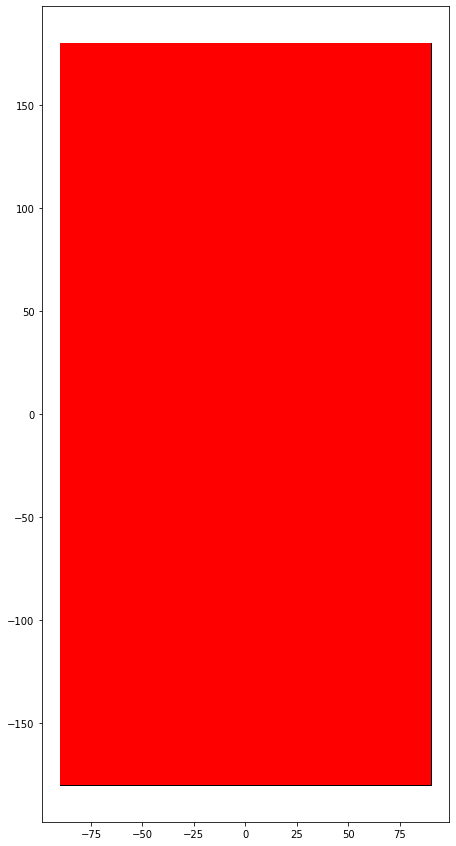

In [50]:
ax = gdf.plot(color='white', edgecolor='black', figsize=(15,15))
gdf.plot(ax=ax, color='red') # We can now plot our ``GeoDataFrame``.

In [11]:
pdf.to_parquet('test_obis.parquet')

In [51]:
gdf.to_file("test_obis.geojson", driver='GeoJSON')

### Save to JSON Lines format


In [14]:
# Convert data frame to JSON lines format
json_lines = pdf.to_json(orient='records', lines=True)

# Write JSON lines to a file
with open("pdf.jsonl", "w") as f:
    f.write(json_lines)

## Dashboard product

In this section we will loop over the files, load them and query and then save to parquet


In [23]:
for u in urls:
    print("Loading {}".format(u))
    g = ConjunctiveGraph()
    g.parse(u, format="nquads")
    print(len(g))
    namespaces = {
        "shacl":   "http://www.w3.org/ns/shacl#" ,
        "schema":   "https://schema.org/" ,
        "schemawrong": "http://schema.org/",
        "geo":      "http://www.opengis.net/ont/geosparql#",
    }

    # get the name of the provider from the release graph file name
    result = re.search('(?:summoned)(.*)(?:_v1_)', u)
    extracted_text = result.group(1)

    # import the file
    kg = kglab.KnowledgeGraph(name = "OIH test", base_uri = "https://oceaninfohub.org/id/", namespaces = namespaces, use_gpus=True, import_graph = g)

    # run the query
    pdf = kg.query_as_df(sparqlcore)

    # add a column with the provider name in it
    pdf['provder'] = extracted_text

    # save to parquet
    pdf.to_parquet('./graphparquet/{}.parquet'.format(extracted_text))



Loading http://ossapi.oceaninfohub.org/public/graphs/summonedafricaioc_v1_release.nq
3193
Loading http://ossapi.oceaninfohub.org/public/graphs/summonedaquadocs_v1_release.nq
1102997
Loading http://ossapi.oceaninfohub.org/public/graphs/summonedcioos_v1_release.nq
145779
Loading http://ossapi.oceaninfohub.org/public/graphs/summonededmerp_v1_release.nq
73543
Loading http://ossapi.oceaninfohub.org/public/graphs/summonededmo_v1_release.nq
101850
Loading http://ossapi.oceaninfohub.org/public/graphs/summonedemodnet_v1_release.nq
1245
Loading http://ossapi.oceaninfohub.org/public/graphs/summonedinanodc_v1_release.nq
499
Loading http://ossapi.oceaninfohub.org/public/graphs/summonedinvemardocuments_v1_release.nq
133485
Loading http://ossapi.oceaninfohub.org/public/graphs/summonedinvemarexperts_v1_release.nq
14638
Loading http://ossapi.oceaninfohub.org/public/graphs/summonedinvemarinstitutions_v1_release.nq
3221
Loading http://ossapi.oceaninfohub.org/public/graphs/summonedinvemartraining_v1_relea

In [27]:
import pandas as pd

directory = './graphparquet'

# This will list all files in the directory that end with .parquet.
files = [f for f in os.listdir(directory) if f.endswith('.parquet')]

# Empty DataFrame to which we'll append each individual file.
combined_df = pd.DataFrame()

for file in files:
    # Complete file path.
    file_path = os.path.join(directory, file)

    # Read the parquet file.
    df = pd.read_parquet(file_path)

    # Append it to the combined DataFrame.
    combined_df = combined_df.append(df)

# If you want to write this combined DataFrame to a new Parquet file:
combined_df.to_parquet('combined.parquet')

## Full RDF graph build

The following will load all the graphs of the providers in the OIH-Graph.

In [7]:
bg = ConjunctiveGraph()

for u in urls:
    print("Loading {}".format(u))
    bg.parse(u, format="nquads")

print(len(bg))

Loading http://ossapi.oceaninfohub.org/public/graphs/summonedafricaioc_v1_release.nq
Loading http://ossapi.oceaninfohub.org/public/graphs/summonedaquadocs_v1_release.nq
Loading http://ossapi.oceaninfohub.org/public/graphs/summonedcioos_v1_release.nq
Loading http://ossapi.oceaninfohub.org/public/graphs/summonededmerp_v1_release.nq
Loading http://ossapi.oceaninfohub.org/public/graphs/summonededmo_v1_release.nq
Loading http://ossapi.oceaninfohub.org/public/graphs/summonedemodnet_v1_release.nq
Loading http://ossapi.oceaninfohub.org/public/graphs/summonedinanodc_v1_release.nq
Loading http://ossapi.oceaninfohub.org/public/graphs/summonedinvemardocuments_v1_release.nq
Loading http://ossapi.oceaninfohub.org/public/graphs/summonedinvemarexperts_v1_release.nq
Loading http://ossapi.oceaninfohub.org/public/graphs/summonedinvemarinstitutions_v1_release.nq
Loading http://ossapi.oceaninfohub.org/public/graphs/summonedinvemartraining_v1_release.nq
Loading http://ossapi.oceaninfohub.org/public/graphs/s

In [8]:
namespaces = {
    "shacl":   "http://www.w3.org/ns/shacl#" ,
    "schema":   "https://schema.org/" ,
    "schemawrong": "http://schema.org/",
    "geo":      "http://www.opengis.net/ont/geosparql#",
}

bkg = kglab.KnowledgeGraph(name = "OIH test", base_uri = "https://oceaninfohub.org/id/", use_gpus=True, namespaces = namespaces, import_graph = bg)

In [9]:
bkg.save_parquet("OIHGraph_rdf.parquet")
